# Finding similar documents with Word2Vec and WMD 

Word Mover's Distance is a promising new tool in machine learning that allows us to submit a query and return the most relevant documents. For example, in a blog post [OpenTable](http://tech.opentable.com/2015/08/11/navigating-themes-in-restaurant-reviews-with-word-movers-distance/) use WMD on restaurant reviews. Using this approach, they are able to mine different aspects of the reviews. In **part 2** of this tutorial, we show how you can use Gensim's `WmdSimilarity` to do something similar to what OpenTable did. In **part 1** shows how you can compute the WMD distance between two documents using `wmdistance`. Part 1 is optional if you want use `WmdSimilarity`, but is also useful in it's own merit.

First, however, we go through the basics of what WMD is.

## Word Mover's Distance basics

WMD is a method that allows us to assess the "distance" between two documents in a meaningful way, even when they have no words in common. It uses [word2vec](http://rare-technologies.com/word2vec-tutorial/) [4] vector embeddings of words. It been shown to outperform many of the state-of-the-art methods in *k*-nearest neighbors classification [3].

WMD is illustrated below for two very similar sentences (illustration taken from [Vlad Niculae's blog](http://vene.ro/blog/word-movers-distance-in-python.html)). The sentences have no words in common, but by matching the relevant words, WMD is able to accurately measure the (dis)similarity between the two sentences. The method also uses the bag-of-words representation of the documents (simply put, the word's frequencies in the documents), noted as $d$ in the figure below. The intution behind the method is that we find the minimum "traveling distance" between documents, in other words the most efficient way to "move" the distribution of document 1 to the distribution of document 2.

<img src='https://vene.ro/images/wmd-obama.png' height='600' width='600'>


This method was introduced in the article "From Word Embeddings To Document Distances" by Matt Kusner et al. ([link to PDF](http://jmlr.org/proceedings/papers/v37/kusnerb15.pdf)). It is inspired by the "Earth Mover's Distance", and employs a solver of the "transportation problem".

In this tutorial, we will learn how to use Gensim's WMD functionality, which consists of the `wmdistance` method for distance computation, and the `WmdSimilarity` class for corpus based similarity queries.

> **Note**:
>
> If you use this software, please consider citing [1], [2] and [3].
>

## Running this notebook

You can download this [iPython Notebook](http://ipython.org/notebook.html), and run it on your own computer, provided you have installed Gensim, PyEMD, NLTK, and downloaded the necessary data.

The notebook was run on an Ubuntu machine with an Intel core i7-4770 CPU 3.40GHz (8 cores) and 32 GB memory. Running the entire notebook on this machine takes about 3 minutes.

## Part 1: Computing the Word Mover's Distance

To use WMD, we need some word embeddings first of all. You could train a word2vec (see tutorial [here](http://rare-technologies.com/word2vec-tutorial/)) model on some corpus, but we will start by downloading some pre-trained word2vec embeddings. Download the GoogleNews-vectors-negative300.bin.gz embeddings [here](https://code.google.com/archive/p/word2vec/) (warning: 1.5 GB, file is not needed for part 2). Training your own embeddings can be beneficial, but to simplify this tutorial, we will be using pre-trained embeddings at first.

Let's take some sentences to compute the distance between.

In [1]:
from time import time
start_nb = time()

In [2]:
# Initialize logging.
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s')

sentence_obama = 'Obama speaks to the media in Illinois'
sentence_president = 'The president greets the press in Chicago'
sentence_obama = sentence_obama.lower().split()
sentence_president = sentence_president.lower().split()

These sentences have very similar content, and as such the WMD should be low. Before we compute the WMD, we want to remove stopwords ("the", "to", etc.), as these do not contribute a lot to the information in the sentences.

In [3]:
# Import and download stopwords from NLTK.
from nltk.corpus import stopwords
from nltk import download
download('stopwords')  # Download stopwords list.

# Remove stopwords.
stop_words = stopwords.words('english')
sentence_obama = [w for w in sentence_obama if w not in stop_words]
sentence_president = [w for w in sentence_president if w not in stop_words]

[nltk_data] Downloading package stopwords to /home/sonic/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now, as mentioned earlier, we will be using some downloaded pre-trained embeddings. We load these into a Gensim Word2Vec model class. Note that the embeddings we have chosen here require a lot of memory.

In [4]:
start = time()
import os

from gensim.models import KeyedVectors
if not os.path.exists('data/GoogleNews-vectors-negative300.bin.gz'):
    raise ValueError("SKIP: You need to download the google news model")
    
model = KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary=True)

print('Cell took %.2f seconds to run.' % (time() - start))

Cell took 81.06 seconds to run.


So let's compute WMD using the `wmdistance` method.

In [5]:
distance = model.wmdistance(sentence_obama, sentence_president)
print("distance = {0:.4f}".format(distance))

distance = 3.3741


Let's try the same thing with two completely unrelated sentences. Notice that the distance is larger.

In [6]:
sentence_orange = 'Oranges are my favorite fruit'
sentence_orange = sentence_orange.lower().split()
sentence_orange = [w for w in sentence_orange if w not in stop_words]

distance = model.wmdistance(sentence_obama, sentence_orange)
print("distance = {0:.4f}".format(distance))

distance = 4.3802


### Normalizing word2vec vectors

When using the `wmdistance` method, it is beneficial to normalize the word2vec vectors first, so they all have equal length. To do this, simply call `model.init_sims(replace=True)` and Gensim will take care of that for you.

Usually, one measures the distance between two word2vec vectors using the cosine distance (see [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity)), which measures the angle between vectors. WMD, on the other hand, uses the Euclidean distance. The Euclidean distance between two vectors might be large because their lengths differ, but the cosine distance is small because the angle between them is small; we can mitigate some of this by normalizing the vectors.

Note that normalizing the vectors can take some time, especially if you have a large vocabulary and/or large vectors.

Usage is illustrated in the example below. It just so happens that the vectors we have downloaded are already normalized, so it won't do any difference in this case.

In [7]:
# Normalizing word2vec vectors.
start = time()

model.init_sims(replace=True)  # Normalizes the vectors in the word2vec class.

distance = model.wmdistance(sentence_obama, sentence_president)  # Compute WMD as normal.

print ('Cell took %.2f seconds to run.' %(time() - start))

Cell took 13.02 seconds to run.


## Part 2: Similarity queries using `WmdSimilarity`

You can use WMD to get the most similar documents to a query, using the `WmdSimilarity` class. Its interface is similar to what is described in the [Similarity Queries](https://radimrehurek.com/gensim/tut3.html) Gensim tutorial.

> **Important note:**
>
> WMD is a measure of *distance*. The similarities in `WmdSimilarity` are simply the *negative distance*. Be careful not to confuse distances and similarities. Two similar documents will have a *high* similarity score and a small distance; two very different documents will have *low* similarity score, and a large distance.

### Yelp data

Let's try similarity queries using some real world data. For that we'll be using Yelp reviews, available at http://www.yelp.com/dataset_challenge. Specifically, we will be using reviews of a single restaurant, namely the [Mon Ami Gabi](http://en.yelp.be/biz/mon-ami-gabi-las-vegas-2).

To get the Yelp data, you need to register by name and email address. The data is 775 MB.

This time around, we are going to train the Word2Vec embeddings on the data ourselves. One restaurant is not enough to train Word2Vec properly, so we use 6 restaurants for that, but only run queries against one of them. In addition to the Mon Ami Gabi, mentioned above, we will be using:

* [Earl of Sandwich](http://en.yelp.be/biz/earl-of-sandwich-las-vegas).
* [Wicked Spoon](http://en.yelp.be/biz/wicked-spoon-las-vegas).
* [Serendipity 3](http://en.yelp.be/biz/serendipity-3-las-vegas).
* [Bacchanal Buffet](http://en.yelp.be/biz/bacchanal-buffet-las-vegas-7).
* [The Buffet](http://en.yelp.be/biz/the-buffet-las-vegas-6).

The restaurants we chose were those with the highest number of reviews in the Yelp dataset. Incidentally, they all are on the Las Vegas Boulevard. The corpus we trained Word2Vec on has 18957 documents (reviews), and the corpus we used for `WmdSimilarity` has 4137 documents.

Below a JSON file with Yelp reviews is read line by line, the text is extracted, tokenized, and stopwords and punctuation are removed.


In [8]:
# Pre-processing a document.

from nltk import word_tokenize
download('punkt')  # Download data for tokenizer.

def preprocess(doc):
    doc = doc.lower()  # Lower the text.
    doc = word_tokenize(doc)  # Split into words.
    doc = [w for w in doc if not w in stop_words]  # Remove stopwords.
    doc = [w for w in doc if w.isalpha()]  # Remove numbers and punctuation.
    return doc

[nltk_data] Downloading package punkt to /home/sonic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
start = time()

import json

# Business IDs of the restaurants.
ids = ['4bEjOyTaDG24SY5TxsaUNQ', '2e2e7WgqU1BnpxmQL5jbfw', 'zt1TpTuJ6y9n551sw9TaEg',
      'Xhg93cMdemu5pAMkDoEdtQ', 'sIyHTizqAiGu12XMLX3N3g', 'YNQgak-ZLtYJQxlDwN-qIg']

w2v_corpus = []  # Documents to train word2vec on (all 6 restaurants).
wmd_corpus = []  # Documents to run queries against (only one restaurant).
documents = []  # wmd_corpus, with no pre-processing (so we can see the original documents).
with open('data/yelp/yelp_academic_dataset_review.json') as data_file:
    for line in data_file:
        json_line = json.loads(line)
        
#         if json_line['business_id'] not in ids:
#             # Not one of the 6 restaurants.
#             continue
        
        # Pre-process document.
        text = json_line['text']  # Extract text from JSON object.
        text = preprocess(text)
        
        # Add to corpus for training Word2Vec.
        w2v_corpus.append(text)
#         print (text)
        
        
        if json_line['business_id'] == ids[0]:
            # Add to corpus for similarity queries.
            wmd_corpus.append(text)
            documents.append(json_line['text'])

            
# print (w2v_corpus)
print ('Cell took %.2f seconds to run.' %(time() - start))

Below is a plot with a histogram of document lengths and includes the average document length as well. Note that these are the pre-processed documents, meaning stopwords are removed, punctuation is removed, etc. Document lengths have a high impact on the running time of WMD, so when comparing running times with this experiment, the number of documents in query corpus (about 4000) and the length of the documents (about 62 words on average) should be taken into account.

[]


/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/local/lib/python3.5/dist-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


ZeroDivisionError: float division by zero

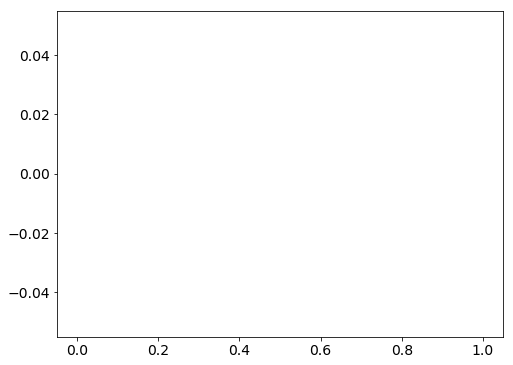

In [26]:
from matplotlib import pyplot as plt
%matplotlib inline

# Document lengths.
lens = [len(doc) for doc in wmd_corpus]

# print (w2v_corpus)

# Plot.
plt.rc('figure', figsize=(8,6))
plt.rc('font', size=14)
plt.rc('lines', linewidth=2)
plt.rc('axes', color_cycle=('#377eb8','#e41a1c','#4daf4a',
                            '#984ea3','#ff7f00','#ffff33'))
# Histogram.
plt.hist(lens, bins=20)
plt.hold(True)
# Average length.
avg_len = sum(lens) / float(len(lens))
plt.axvline(avg_len, color='#e41a1c')
plt.hold(False)
plt.title('Histogram of document lengths.')
plt.xlabel('Length')
plt.text(100, 800, 'mean = %.2f' % avg_len)
plt.show()

Now we want to initialize the similarity class with a corpus and a word2vec model (which provides the embeddings and the `wmdistance` method itself).

In [13]:
# Train Word2Vec on all the restaurants.
model = Word2Vec(w2v_corpus, workers=3, size=100)

# Initialize WmdSimilarity.
from gensim.similarities import WmdSimilarity
num_best = 10
instance = WmdSimilarity(wmd_corpus, model, num_best=10)

The `num_best` parameter decides how many results the queries return. Now let's try making a query. The output is a list of indeces and similarities of documents in the corpus, sorted by similarity.

Note that the output format is slightly different when `num_best` is `None` (i.e. not assigned). In this case, you get an array of similarities, corresponding to each of the documents in the corpus.

The query below is taken directly from one of the reviews in the corpus. Let's see if there are other reviews that are similar to this one.

In [15]:
start = time()

sent = 'Very good, you should seat outdoor.'
query = preprocess(sent)

sims = instance[query]  # A query is simply a "look-up" in the similarity class.

print 'Cell took %.2f seconds to run.' %(time() - start)

Cell took 51.17 seconds to run.


The query and the most similar documents, together with the similarities, are printed below. We see that the retrieved documents are discussing the same thing as the query, although using different words. The query talks about getting a seat "outdoor", while the results talk about sitting "outside", and one of them says the restaurant has a "nice view".

In [16]:
# Print the query and the retrieved documents, together with their similarities.
print 'Query:'
print sent
for i in range(num_best):
    print
    print 'sim = %.4f' % sims[i][1]
    print documents[sims[i][0]]

Query:
Very good, you should seat outdoor.

sim = 1.0000
Very good, you should seat outdoor.

sim = 0.5998
It's a great place if you can sit outside in good weather.

sim = 0.5798
It was good I like the outside

sim = 0.5495
Always a good bet.

sim = 0.5478
Sat outside under heat lamps.  Good service and good food.  Wonderful place

sim = 0.5474
Patio is awesome but can get crowded.

sim = 0.5464
The steak was good. Prices reasonable for the strip and it was a great view with the outdoor seating.

sim = 0.5453
Best seat in the house with view of water fountain, good wine, good food n good service.

sim = 0.5443
nice view, good service

sim = 0.5403
Good value restaurant on strip! 
Great view take outside seat good food!
However, be sure you make reservation!


Let's try a different query, also taken directly from one of the reviews in the corpus.

In [17]:
start = time()

sent = 'I felt that the prices were extremely reasonable for the Strip'
query = preprocess(sent)

sims = instance[query]  # A query is simply a "look-up" in the similarity class.

print 'Query:'
print sent
for i in range(num_best):
    print
    print 'sim = %.4f' % sims[i][1]
    print documents[sims[i][0]]

print '\nCell took %.2f seconds to run.' %(time() - start)

Query:
I felt that the prices were extremely reasonable for the Strip

sim = 0.5691
Reasonable prices. Makes for a nice dinner out in the town.

sim = 0.5485
The steak was good. Prices reasonable for the strip and it was a great view with the outdoor seating.

sim = 0.5457
Exceptional food at reasonable prices.  Reservations are a must.

sim = 0.5378
Good food, great atmosphere, reasonable prices.  Right in the middle of the Strip.  Nothing not to like here.

sim = 0.5376
Incredible restaurant on the strip! Very reasonable prices, outstanding service, an breathtaking views. Bar none, my favorite meal on the Strip.

sim = 0.5346
don't let the tourist location throw you. terrific French food on the strip without the strip prices.

sim = 0.5334
Had lunch here, food price was very reasonable for vegas and the atmosphere was great.

sim = 0.5278
Nice place to take a date at a reasonable price.

sim = 0.5264
Really good food at decent prices (for being on the strip).  Not a traditional steak

This time around, the results are more straight forward; the retrieved documents basically contain the same words as the query.

`WmdSimilarity` normalizes the word embeddings by default (using `init_sims()`, as explained before), but you can overwrite this behaviour by calling `WmdSimilarity` with `normalize_w2v_and_replace=False`.

In [36]:
print 'Notebook took %.2f seconds to run.' %(time() - start_nb)

Notebook took 181.05 seconds to run.


## References

1. Ofir Pele and Michael Werman, *A linear time histogram metric for improved SIFT matching*, 2008.
* Ofir Pele and Michael Werman, *Fast and robust earth mover's distances*, 2009.
* Matt Kusner et al. *From Embeddings To Document Distances*, 2015.
* Thomas Mikolov et al. *Efficient Estimation of Word Representations in Vector Space*, 2013.